In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import Grouper
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [ ]:
House = pd.read_csv("chips1.csv")

In [ ]:
House.head(10)

,DATE,price
0,01-01-1980,1.981
1,01-02-1980,1.994
2,01-03-1980,2.003
3,01-04-1980,2.006
4,01-05-1980,2.006
5,01-06-1980,2.018
6,01-07-1980,2.012
7,01-08-1980,2.046
8,01-09-1980,2.035
9,01-10-1980,2.066


In [ ]:
House.DATE=pd.to_datetime(House.DATE,dayfirst=True)

In [ ]:
House.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    492 non-null    datetime64[ns]
 1   price   492 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.8 KB


In [ ]:
House1=House.copy()

In [ ]:
House1['year']=House1['DATE'].dt.year

In [ ]:
fig = px.box(House1, x="year", y="price",title='Year-wise boxplot ')
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:
House2 = House.copy()

In [ ]:
House2.set_index('DATE', inplace=True)

In [ ]:
House2.head()

,price
DATE,
1980-01-01,1.981
1980-02-01,1.994
1980-03-01,2.003
1980-04-01,2.006
1980-05-01,2.006


In [ ]:
len(House2)

492

In [ ]:
fig = px.line(House2, x=House2.index, y='price', title='Time Series Plot Monthly Average Price of Potato Chips')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

from above plot of the data we can obseve that there is slide increasing trend and some periodicity with uneven hights( i.e. some seasonal cycle is wider and taller than other). This implies that we have to use atleast one lag of differencing once and period-lag of differencing once.
Hint about model:- d=1 and D=1

In [ ]:
train = pd.DataFrame(House2[:int(0.85*len(House2))])
test = pd.DataFrame(House2[int(0.85*len(House2)):])

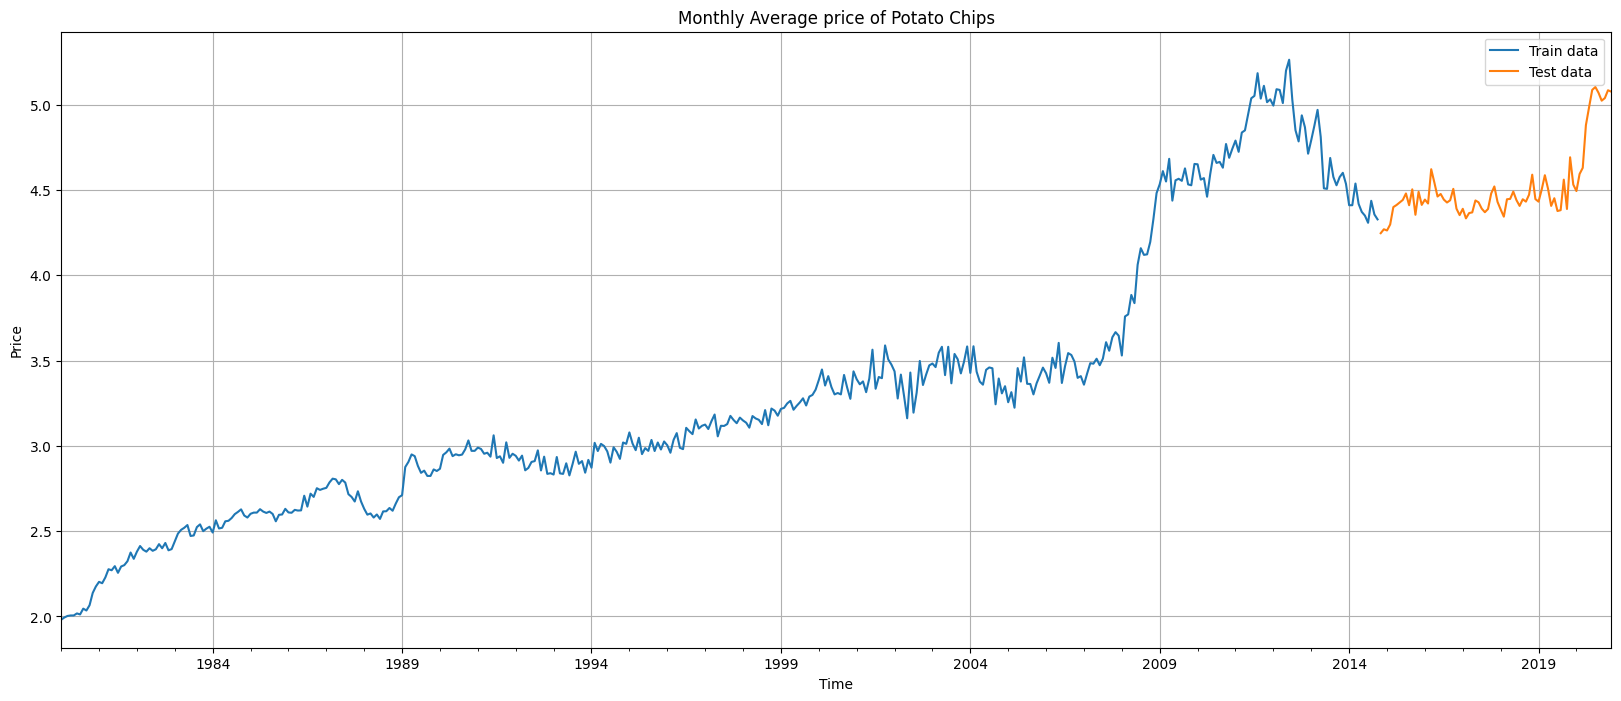

In [ ]:
### Visulaise our data
fig,ax= plt.subplots(figsize=(20,8))
train.plot(kind='line',ax =ax)
test.plot(kind='line',ax =ax)
plt.xlabel('Time')
plt.ylabel("Price")
plt.title("Monthly Average price of Potato Chips")
plt.legend(['Train data','Test data'])
plt.grid()
plt.show()

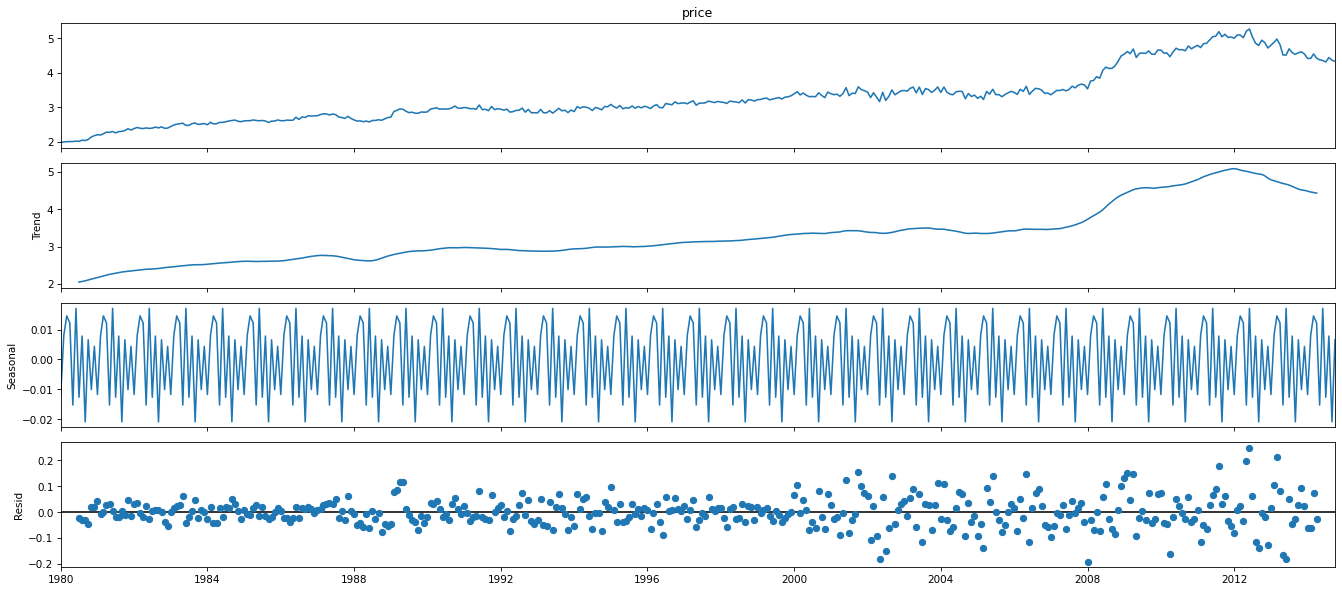

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train['price'],model = "additive")
s_dec_additive.plot()
plt.show()

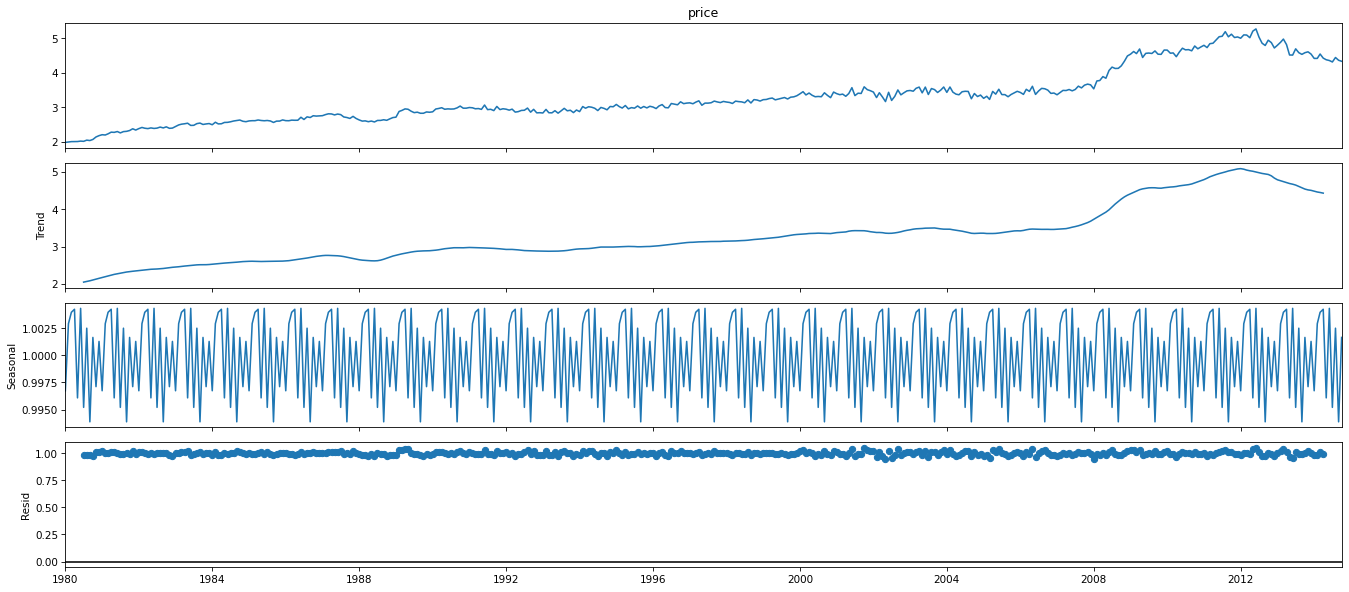

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train['price'],model = "multiplicative")
s_dec_additive.plot()
plt.show()

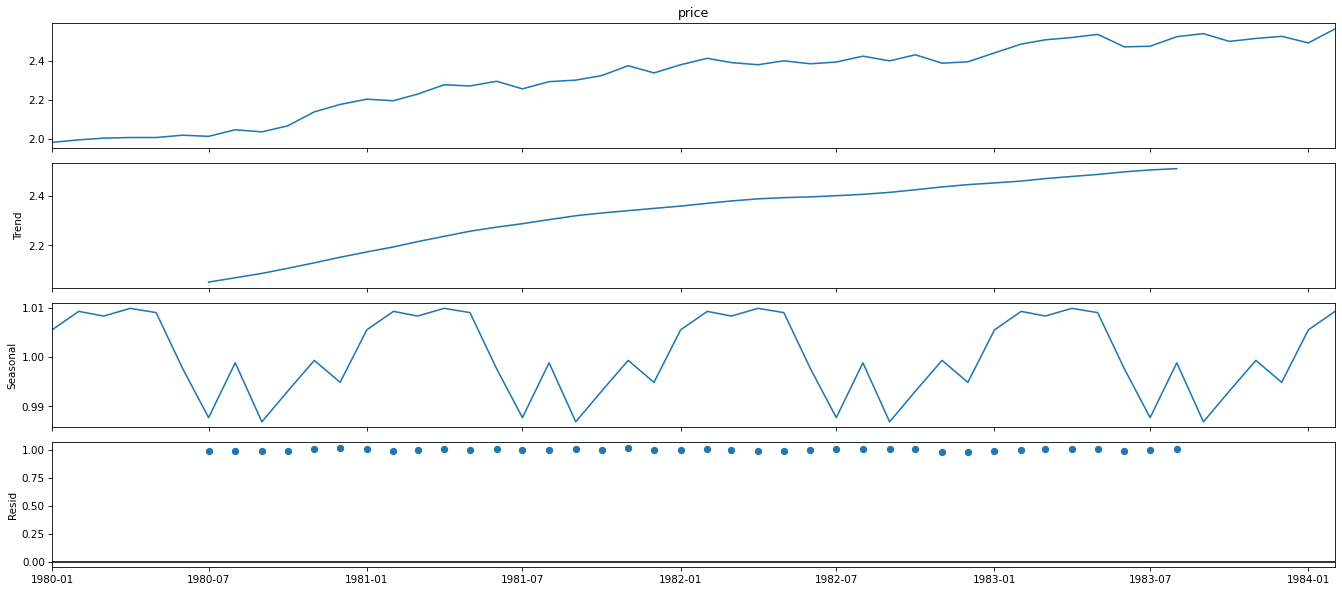

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train['price'][:50],model = "multiplicative")
s_dec_additive.plot()
plt.show()

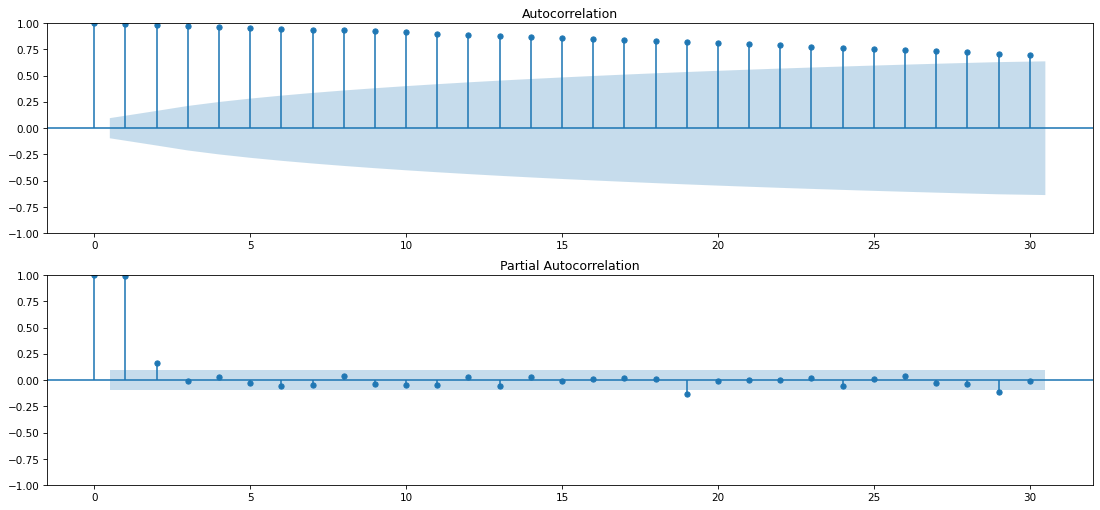

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(train['price'], lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(train['price'], lags=30, ax=plt.gca())
plt.show()

In [ ]:
result = adfuller(train['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.182860
p-value: 0.680925
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [ ]:
diff1 = train['price'].diff().dropna()

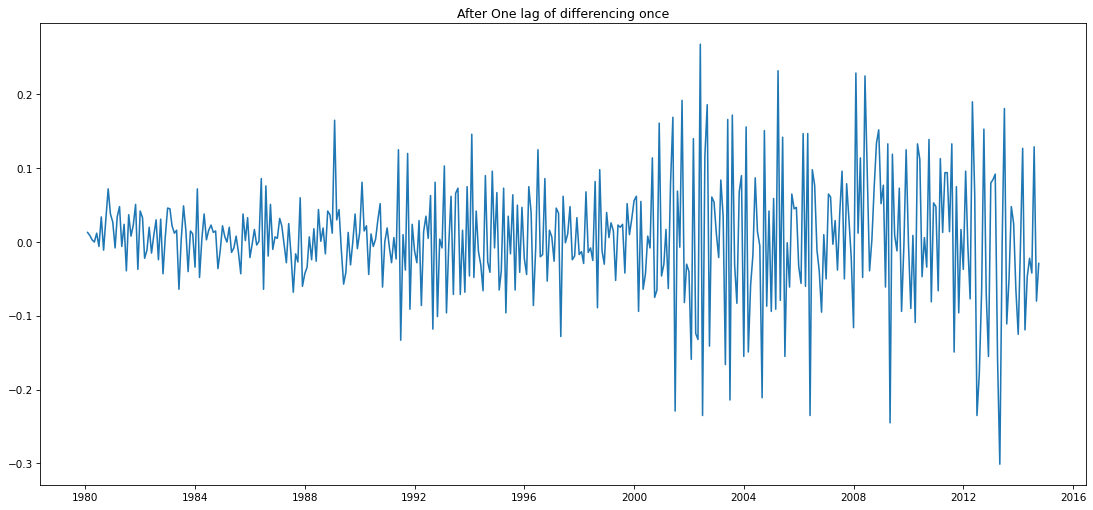

In [ ]:
plt.plot(diff1)
plt.title("After One lag of differencing once")
plt.show()

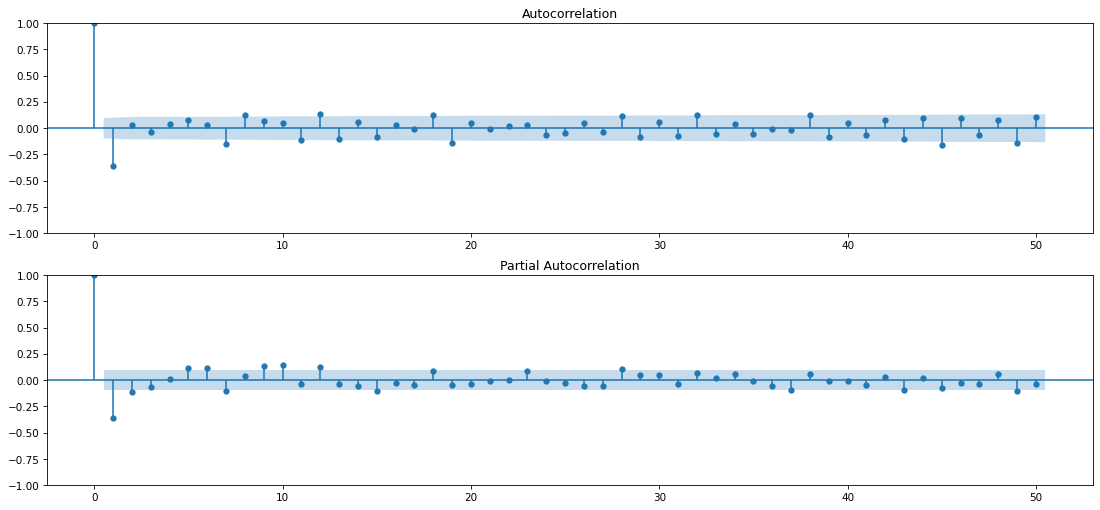

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff1, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff1, lags=50, ax=plt.gca())
plt.show()

In [ ]:
diff2= diff1.diff().dropna()

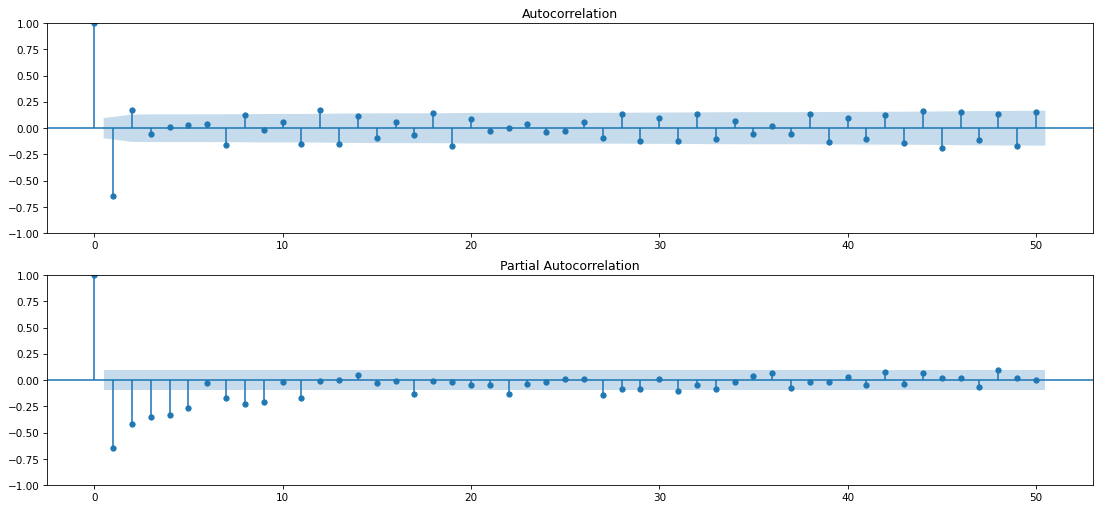

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff2, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff2, lags=50, ax=plt.gca())
plt.show()

In [ ]:
result = adfuller(diff1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.985024
p-value: 0.001491
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [ ]:
diff12 = diff1.diff(12).dropna()

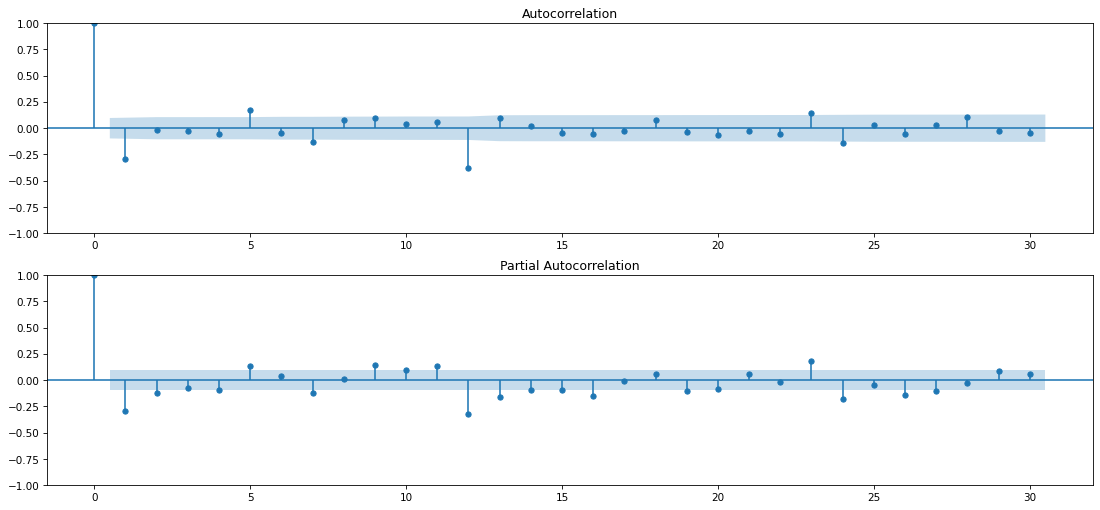

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff12, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff12, lags=30, ax=plt.gca())
plt.show()

In [ ]:
diff24 = diff12.diff(12).dropna()

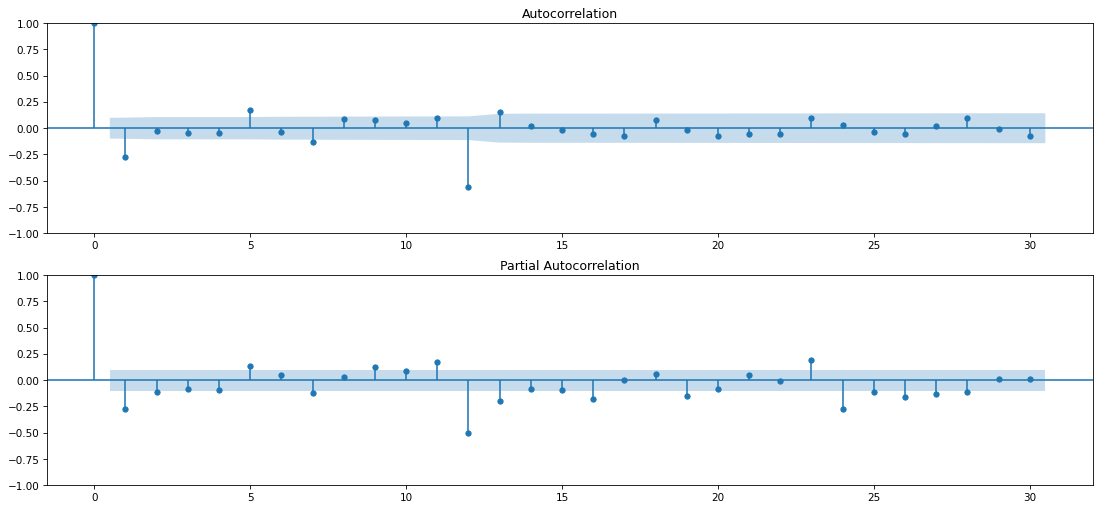

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff24, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff24, lags=30, ax=plt.gca())
plt.show()

In the begining of PACF plot it shows trail off pattern and ACF plot has a cutoff after lag 1. So, we can take non-seasonal ar parameter p=0 and non-seasonal ma parameter q=1.

Also, in both ACF and PACF plot only one seasonal lag i.e. lag 12 is significant. So, we can consider seasonal ar parameter P=1 and seasonal ma parameter Q=1

1. (1,1,1)X(1,1,1,12)
2. (1,1,1)X(2,1,1,12)
3. (1,1,1)X(1,2,1,12)
4. (1,1,1)X(2,2,1,12)

In [ ]:
result = adfuller(diff12)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.047550
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


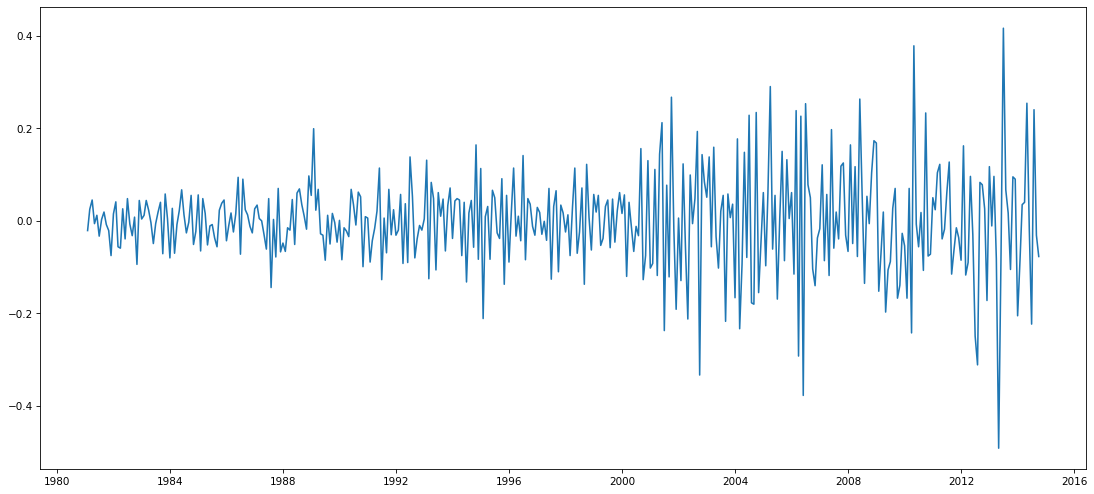

In [ ]:
plt.plot(diff12)
plt.show()

Model-1

In [ ]:
my_order = (1,1,1) #Non-seasonal parameters
my_seasonal_order = (1, 1, 1, 12) # seasonal parameters
# define model
model = SARIMAX(train['price'], order=my_order, seasonal_order=my_seasonal_order)
model_fit=model.fit()

In [ ]:
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  418
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 468.230
Date:                            Sat, 12 Aug 2023   AIC                           -926.461
Time:                                    08:52:23   BIC                           -906.442
Sample:                                01-01-1980   HQIC                          -918.537
                                     - 10-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0095      0.124     -0.077      0.939      -0.252       0.233
ma.L1         -0.3485      0.114   

In [ ]:
fitted1 = model_fit.fittedvalues

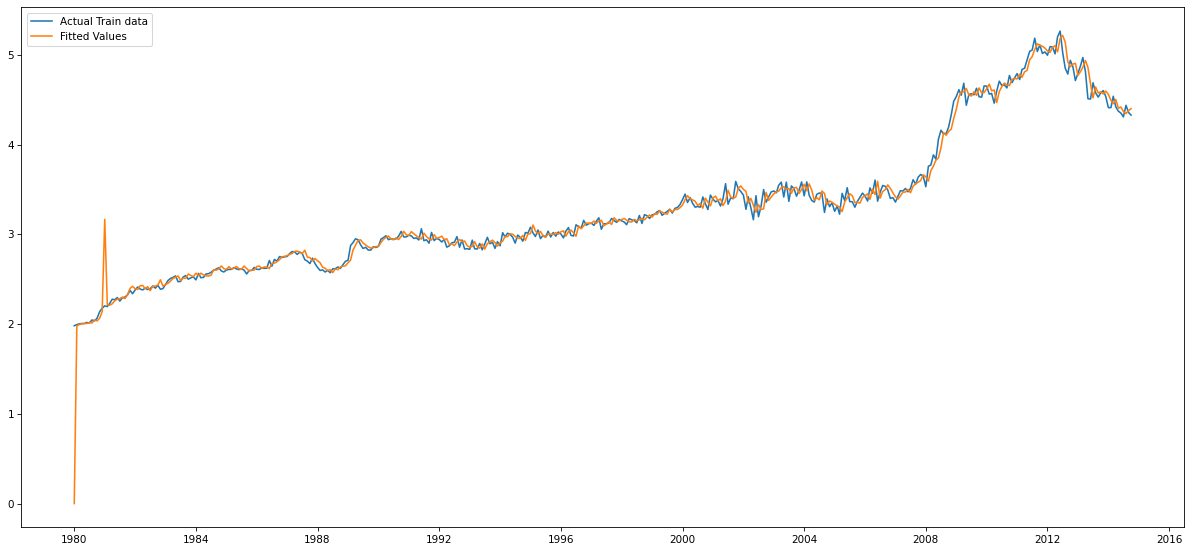

In [ ]:
## Visulaise the data
plt.figure(figsize = (20,9))
plt.plot(train.index, train['price'])
plt.plot(train.index, fitted1)
## forecasted data
#plt.plot(test.index,test['Passengers'])
#plt.plot(test.index,test['pred'])

## margin of error


plt.legend(['Actual Train data','Fitted Values'])
plt.show()

<Figure size 2250x525 with 0 Axes>

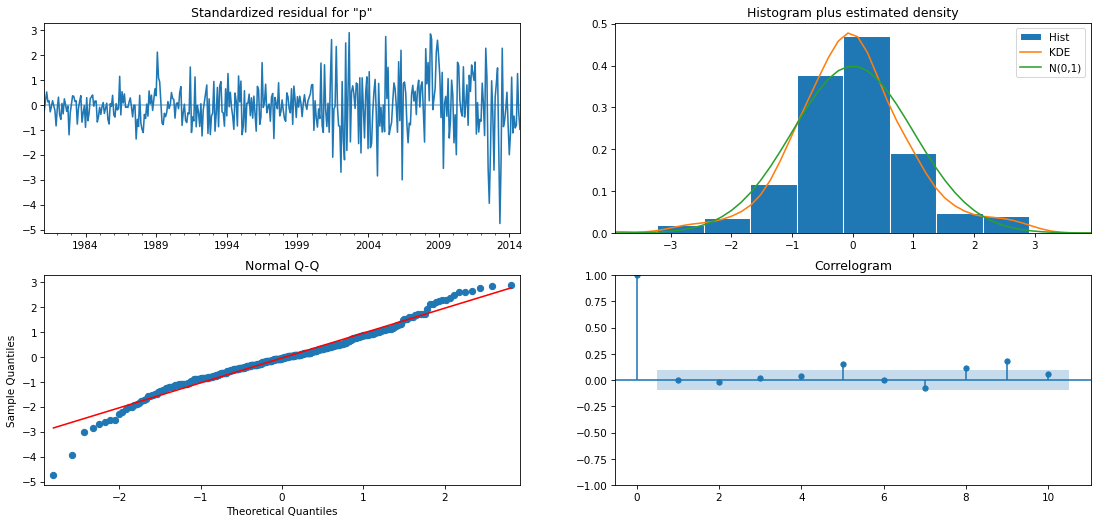

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit.plot_diagnostics()



In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
resid1 = model_fit.resid

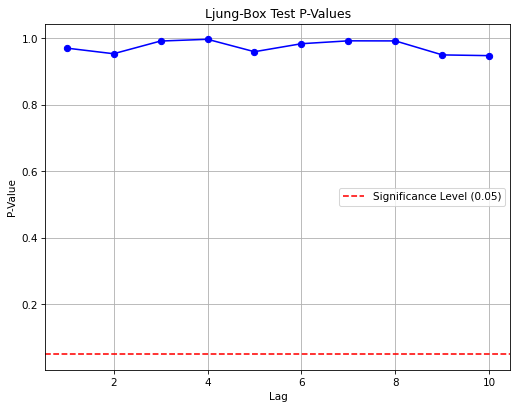

In [ ]:
max_lag = 10
lb1 = acorr_ljungbox(resid1, lags=max_lag)
lb_pvalue = lb1['lb_pvalue']
# Create a list of lag values
lag_values = np.arange(1, max_lag + 1)

# Plot the p-values against the lag values
plt.figure(figsize=(8, 6))
plt.plot(lag_values, lb_pvalue, marker='o', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test['forecasted']=model_fit.forecast(len(test))

fig = px.line(test, x=test.index, y=test.columns,
              title='Test data vs Forecasted')

fig.show()

In [ ]:
test.head(10)

,price,forecasted
DATE,,
2014-11-01,4.247,4.345922
2014-12-01,4.270,4.359009
2015-01-01,4.263,4.339379
2015-02-01,4.298,4.362527
2015-03-01,4.400,4.384150
2015-04-01,4.412,4.377324
2015-05-01,4.427,4.353221
2015-06-01,4.442,4.384583
2015-07-01,4.480,4.359820


In [ ]:
mape = np.round(np.mean(np.abs(test['price']-test['forecasted'])/test['price'])*100,2)

In [ ]:
mape

2.78

Model2

In [ ]:
model2 = SARIMAX(train['price'], order=(1,1,1), seasonal_order=(2,2,1,12))
model_fit2=model2.fit()

In [ ]:
print(model_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  418
Model:             SARIMAX(1, 1, 1)x(2, 2, 1, 12)   Log Likelihood                 377.005
Date:                            Sat, 12 Aug 2023   AIC                           -742.011
Time:                                    08:53:47   BIC                           -718.168
Sample:                                01-01-1980   HQIC                          -732.562
                                     - 10-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0487      0.119      0.411      0.681      -0.184       0.281
ma.L1         -0.4222      0.111   

<Figure size 2250x525 with 0 Axes>

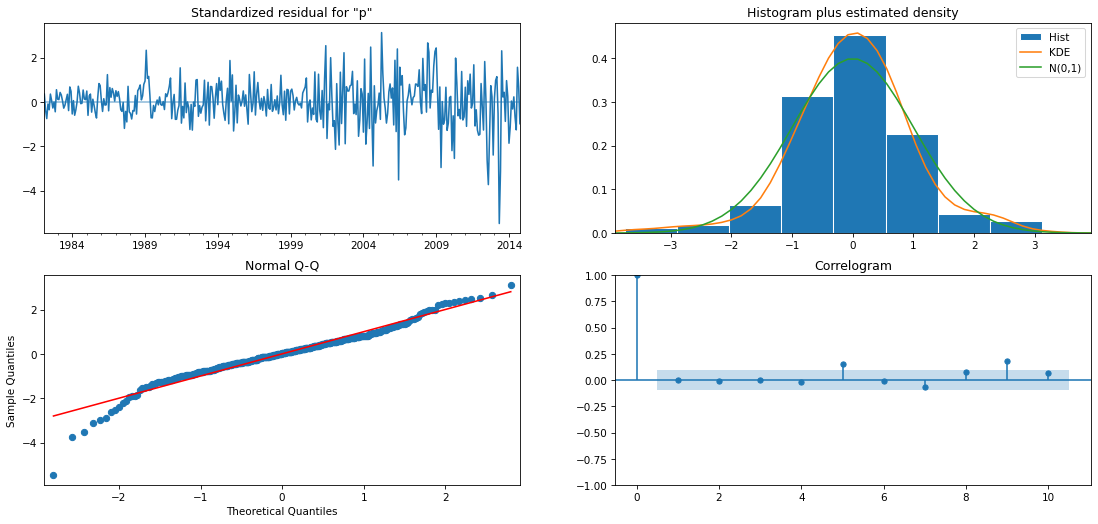

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit2.plot_diagnostics()

In [ ]:
resid4 = model_fit2.resid

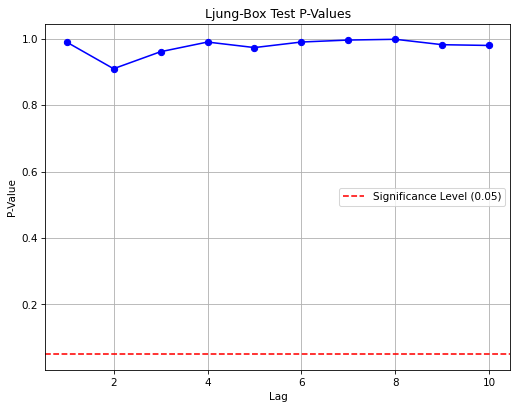

In [ ]:
max_lag = 10
lb1 = acorr_ljungbox(resid4, lags=max_lag)
lb_pvalue = lb1['lb_pvalue']
# Create a list of lag values
lag_values = np.arange(1, max_lag + 1)

# Plot the p-values against the lag values
plt.figure(figsize=(8, 6))
plt.plot(lag_values, lb_pvalue, marker='o', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
_, p_value, _, _ = het_breuschpagan(resid2, train)

In [ ]:
# Breusch Pagan test
_, p_value, _, _ = het_breuschpagan(resid4, train)
# Test the null hypothesis at a certain significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The residuals are likely heteroscedastic (reject null hypothesis).")
else:
    print("The residuals are likely homoscedastic (fail to reject null hypothesis).")

The residuals are likely homoscedastic (fail to reject null hypothesis).


In [ ]:
ME =  1.96*model_fit2.resid.std()
ME

0.25479143500887774

In [ ]:
pred = model_fit2.forecast(len(test))
ci_plus = pred + ME
ci_minus = pred - ME

In [ ]:
test['pred']=pred

In [ ]:
test.tail()

,price,pred
DATE,,
2020-08-01,5.070,4.832334
2020-09-01,5.024,4.808671
2020-10-01,5.039,4.841654
2020-11-01,5.085,4.830376
2020-12-01,5.077,4.851581


In [ ]:
fitted = model_fit2.fittedvalues

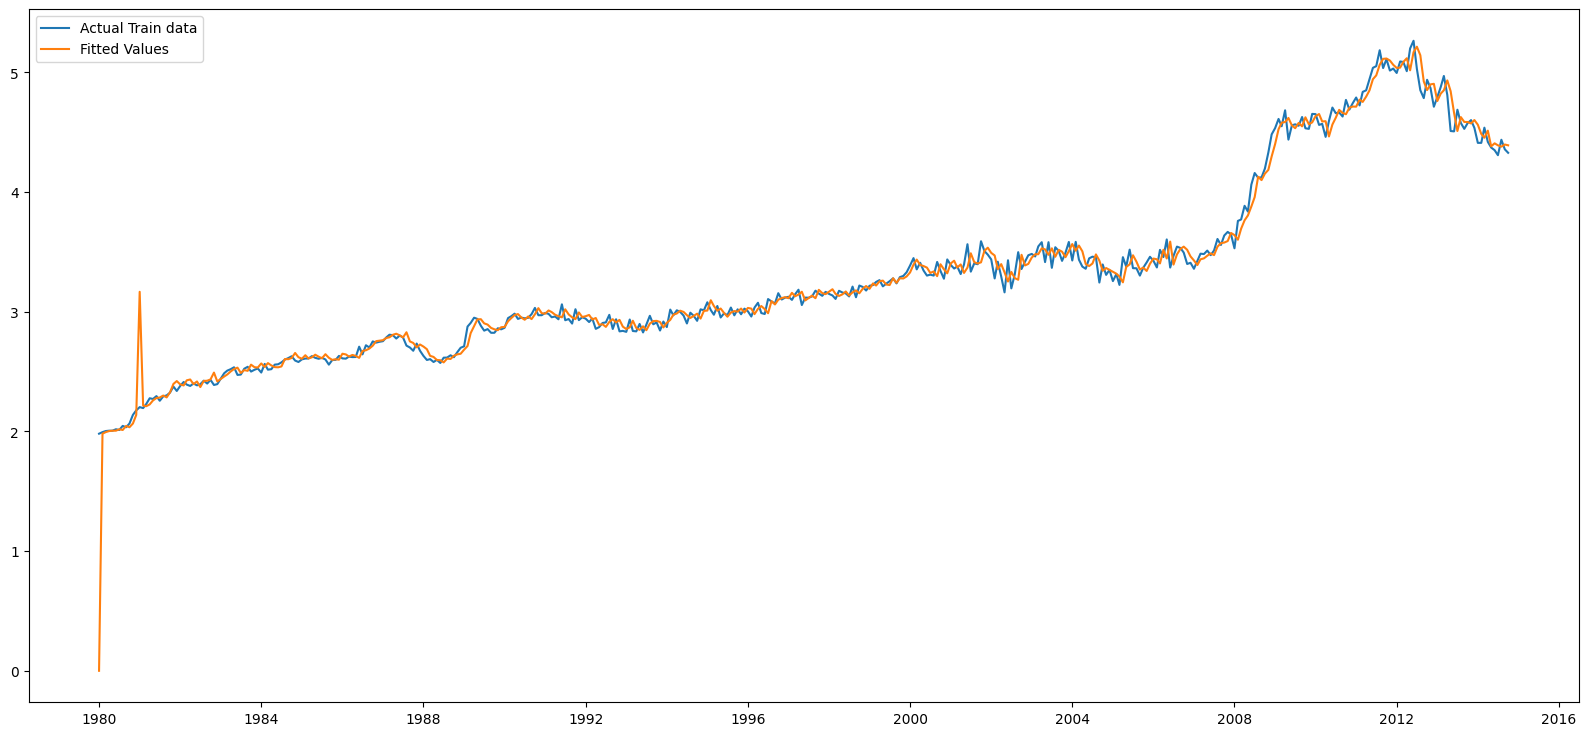

In [ ]:
## Visulaise the data
plt.figure(figsize = (20,9))
plt.plot(train.index, train['price'])
plt.plot(train.index, fitted)
## forecasted data
#plt.plot(test.index,test['Passengers'])
#plt.plot(test.index,test['pred'])

## margin of error


plt.legend(['Actual Train data','Fitted Values'])
plt.show()

In [ ]:
test['forecasted']=model_fit2.forecast(len(test))

fig = px.line(test, x=test.index, y=test.columns,
              title='Test data vs Forecasted')

fig.show()

In [ ]:
test.head(10)

,price,forecasted
DATE,,
2014-11-01,4.247,4.320317
2014-12-01,4.270,4.261681
2015-01-01,4.263,4.201390
2015-02-01,4.298,4.252195
2015-03-01,4.400,4.332922
2015-04-01,4.412,4.212411
2015-05-01,4.427,4.191196
2015-06-01,4.442,4.201223
2015-07-01,4.480,4.137691


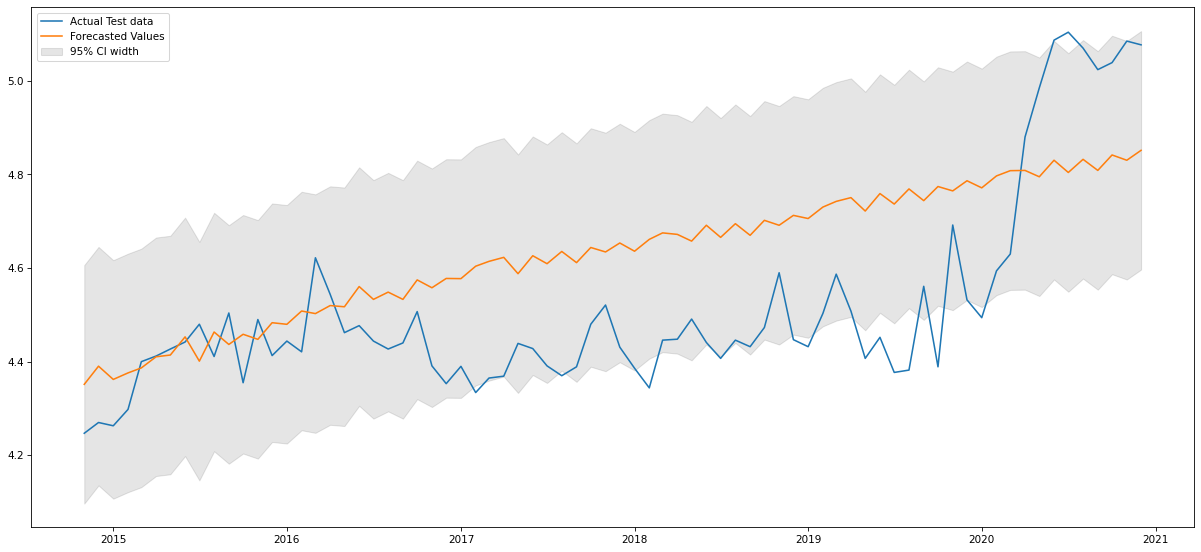

In [ ]:
## Visulaise the data
plt.figure(figsize = (20,9))
#plt.plot(train.index, train['temp'])
## forecasted data
plt.plot(test.index,test['price'])
plt.plot(test.index,test['pred'])

## margin of error

plt.fill_between(test.index,(ci_plus),(ci_minus),alpha = 0.1,color = 'black')

plt.legend(['Actual Test data','Forecasted Values','95% CI width'])
plt.show()

In [ ]:
test['pred']=pred

fig = px.line(test, x=test.index, y=test.columns,
              title='custom tick labels with ticklabelmode="period"')

fig.show()

In [ ]:
mape = np.round(np.mean(np.abs(test['price']-test['forecasted'])/test['price'])*100,2)
mape

24.01